In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import niceprint, nicesubplots, without_diag, bfs_layout

In [2]:
np.random.seed(1)

In [3]:
def make_dag(layers):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    num_nodes_prev = 0
    for i, layer_size in enumerate(layers):
        if i == 0:
            for b in range(layer_size):
                g.add_edge(0, 1+b)
        else:
            prev_layer_size = layers[i - 1]
            for a in range(prev_layer_size):
                for b in range(layer_size):
                    g.add_edge(num_nodes_prev+a, num_nodes+b)
        num_nodes_prev = num_nodes
        num_nodes += layer_size
    g.graph["root"] = 0
    return g

In [4]:
def make_tree(branching_factors):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    nodes_prev_layer = [0]
    for i, factor in enumerate(branching_factors):
        nodes_current_layer = []
        for n in nodes_prev_layer:
            for c in range(factor):
                g.add_edge(n, num_nodes)
                nodes_current_layer.append(num_nodes)
                num_nodes += 1
        nodes_prev_layer = nodes_current_layer
    g.graph["root"] = 0
    return g

In [5]:
num_docs = 5000
words_per_doc = 20
vocab_size = 10

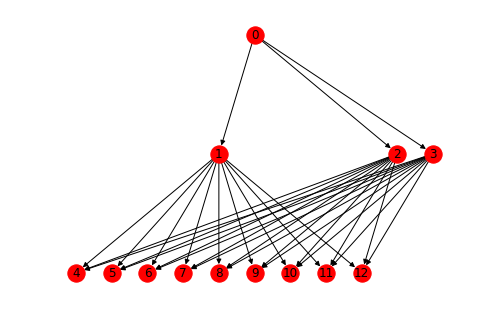

In [6]:
dense_dag = make_dag([3, 9])
nx.draw(dense_dag, pos=bfs_layout(dense_dag), with_labels=True)

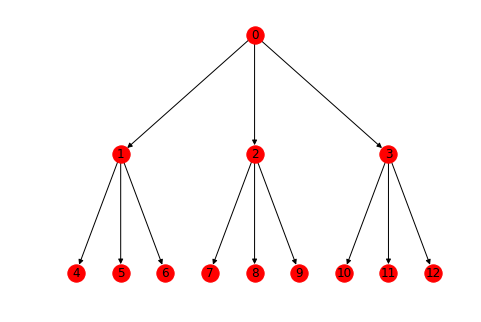

In [7]:
tree = make_tree([3, 3])
nx.draw(tree, pos=bfs_layout(tree), with_labels=True)

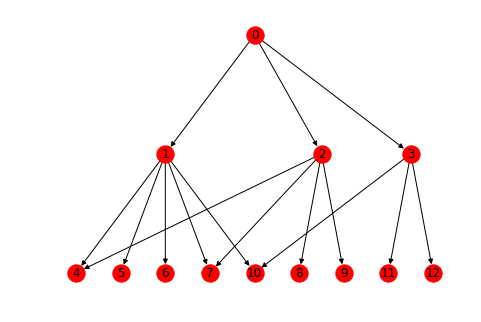

In [8]:
sparse_dag = make_tree([3, 3])
sparse_dag.add_edge(1, 7)
sparse_dag.add_edge(1, 10)
sparse_dag.add_edge(2, 4)
nx.draw(sparse_dag, pos=bfs_layout(sparse_dag), with_labels=True)

In [9]:
def successors(g, node):
    return list(g.successors(node))

def depth(g):
    return nx.algorithms.dag_longest_path_length(g)

In [10]:
class PAMSampler(object):
    def __init__(self, g, num_docs, words_per_doc, vocab_size):
        self.g = g
        self.num_docs = num_docs
        self.words_per_doc = words_per_doc
        self.vocab_size = vocab_size
        
    def sample(self):
        self.thetas_by_doc = []
        self.docs = []
        self.doc_nodes = []
        # Sample topics
        self.topics = dict()
        for node in self.g.nodes():
            nc = len(list(self.g.successors(node)))
            if nc == 0:
                self.topics[node] = np.random.dirichlet(np.ones(self.vocab_size))
        # Sample documents
        for i in tqdm(range(num_docs)):
            thetas = dict()
            for node in self.g.nodes():
                nc = len(list(self.g.successors(node)))
                if nc > 0:
                    alpha = np.ones(nc)
                    thetas[node] = np.random.dirichlet(alpha)
            self.thetas_by_doc.append(thetas)
            current_doc = []
            current_doc_nodes = []
            for j in range(words_per_doc):
                node = self.sample_leaf(thetas)
                current_doc_nodes.append(node)
                word_index = np.random.choice(self.vocab_size, p=self.topics[node])
                current_doc.append(word_index)
            self.docs.append(current_doc)
            self.doc_nodes.append(current_doc_nodes)
        return self
    
    def sample_leaf(self, thetas):
        current = self.g.graph["root"]
        options = successors(self.g, current)
        while len(options) > 0:
            current = options[np.random.choice(len(options), p=thetas[current])]
            options = successors(self.g, current)
        return current

In [11]:
class HPAM1Sampler(object):
    def __init__(self, g, num_docs, words_per_doc, vocab_size):
        self.g = g
        self.num_docs = num_docs
        self.words_per_doc = words_per_doc
        self.vocab_size = vocab_size
        
    def sample(self):
        self.thetas_by_doc = []
        self.docs = []
        self.doc_paths = []
        self.doc_nodes = []
        # Sample topics
        self.topics = dict()
        for node in self.g.nodes():
            self.topics[node] = np.random.dirichlet(np.ones(self.vocab_size))
        # Sample documents
        for i in tqdm(range(num_docs)):
            thetas = dict()
            for node in self.g.nodes():
                nc = len(list(self.g.successors(node)))
                if nc > 0:
                    alpha = np.ones(nc)
                    thetas[node] = np.random.dirichlet(alpha)
            self.thetas_by_doc.append(thetas)
            current_doc = []
            current_doc_paths = []
            current_doc_nodes = []
            for j in range(words_per_doc):
                path = self.sample_leaf_path(thetas)
                current_doc_paths.append(path)
                # NOTE: assuming zeta_{path} is the same for all paths
                depth_distrib = np.ones(len(path)) / float(len(path))
                node = np.random.choice(path, p=depth_distrib)
                current_doc_nodes.append(node)
                word_index = np.random.choice(self.vocab_size, p=self.topics[node])
                current_doc.append(word_index)
            self.docs.append(current_doc)
            self.doc_paths.append(current_doc_paths)
            self.doc_nodes.append(current_doc_nodes)
        return self
    
    def sample_leaf_path(self, thetas):
        path = []
        current = self.g.graph["root"]
        options = successors(self.g, current)
        path.append(current)
        while len(options) > 0:
            current = options[np.random.choice(len(options), p=thetas[current])]
            options = successors(self.g, current)
            path.append(current)
        return path

In [12]:
class HPAM2Sampler(object):
    def __init__(self, g, num_docs, words_per_doc, vocab_size):
        self.g = g
        self.num_docs = num_docs
        self.words_per_doc = words_per_doc
        self.vocab_size = vocab_size
        
    def sample(self):
        self.thetas_by_doc = []
        self.docs = []
        self.doc_nodes = []
        # Sample topics
        self.topics = dict()
        for node in self.g.nodes():
            self.topics[node] = np.random.dirichlet(np.ones(self.vocab_size))
        # Sample documents
        for i in tqdm(range(num_docs)):
            thetas = dict()
            for node in self.g.nodes():
                nc = len(list(self.g.successors(node)))
                if nc > 0:
                    alpha = np.ones(nc + 1)
                    thetas[node] = np.random.dirichlet(alpha)
            self.thetas_by_doc.append(thetas)
            current_doc = []
            current_doc_nodes = []
            for j in range(words_per_doc):
                node = self.sample_node(thetas)
                current_doc_nodes.append(node)
                word_index = np.random.choice(self.vocab_size, p=self.topics[node])
                current_doc.append(word_index)
            self.docs.append(current_doc)
            self.doc_nodes.append(current_doc_nodes)
        return self
    
    def sample_node(self, thetas):
        current = self.g.graph["root"]
        options = successors(self.g, current)
        while len(options) > 0:
            assert len(thetas[current] == len(options) + 1)
            choice = np.random.choice(len(thetas[current]), p=thetas[current])
            if choice == 0:
                return current
            current = options[choice - 1]
            options = successors(self.g, current)
        return current

In [13]:
def coocurrence(sampler):
    num_nodes = np.max(sampler.doc_nodes) + 1
    counts = np.zeros((num_nodes, num_nodes))
    for current_dn in sampler.doc_nodes:
        for i in range(len(current_dn) // 2):
            topic0 = current_dn[2 * i + 0]
            topic1 = current_dn[2 * i + 1]
            counts[topic0, topic1] += 1
    return counts / np.sum(counts)

In [14]:
def niceimshow(X, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(X, **kwargs)
    ax.axis('off')

In [15]:
graphs = [("Tree", tree), ("DenseDAG", dense_dag), ("SparseDAG", sparse_dag)]
sampler_types = [PAMSampler, HPAM1Sampler, HPAM2Sampler]

## Run samplers

Note: time consuming (may skip this section if needed)

In [16]:
samplers = dict()
for graph_name, graph in graphs:
    samplers[graph_name] = dict()
    for s in sampler_types:
        sampler_name = s.__name__
        result = s(graph, num_docs, words_per_doc, vocab_size).sample()
        samplers[graph_name][sampler_name] = result

100%|██████████| 5000/5000 [00:10<00:00, 495.03it/s]


In [17]:
cooccurrence_matrices = dict()
for graph_name, graph in graphs:
    cooccurrence_matrices[graph_name] = dict()
    for sampler_name, result in samplers[graph_name].items():
        m = coocurrence(result)
        cooccurrence_matrices[graph_name][sampler_name] = m

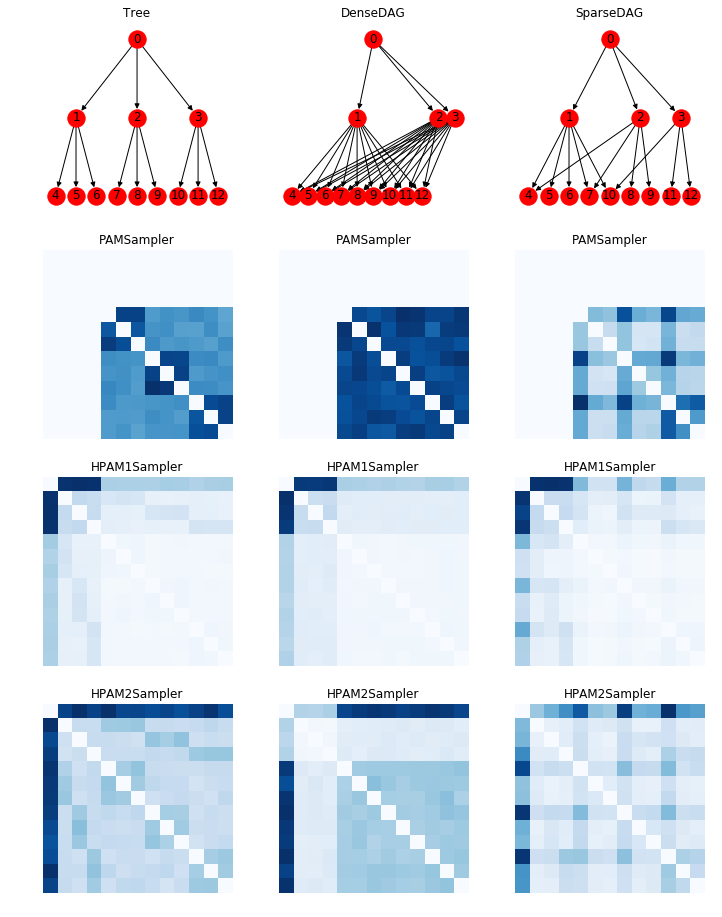

In [18]:
fig, axes = nicesubplots(len(sampler_types) + 1, len(graphs))
for i, (graph_name, graph) in enumerate(graphs):
    #nx.draw_circular(graph, with_labels=True, ax=axes[0,i])
    nx.draw(graph, pos=bfs_layout(graph), with_labels=True, ax=axes[0,i])
    axes[0,i].set_title(graph_name)
    for j, (sampler_name, m) in enumerate(cooccurrence_matrices[graph_name].items()):
        ax = axes[j+1,i]
        niceimshow(without_diag(m), ax = ax, cmap='Blues')  #, vmin=0, vmax=1)
        ax.set_title(sampler_name)

## Direct computation

Trying to compute pairwise probabilities directly

In [19]:
def get_alpha(num_children, pexit = None, scale = 1.0):
    if pexit is None:
        pexit = 1.0 / (num_children + 1)
    pother = (1 - pexit) / float(num_children)
    result = pother * np.ones(num_children + 1)
    result[0] = pexit
    result *= scale * (num_children + 1)
    return result

In [20]:
alpha = get_alpha(4, pexit = 1/2)
print(alpha)
print(alpha[0] / sum(alpha))

[2.5   0.625 0.625 0.625 0.625]
0.5


In [21]:
from collections import defaultdict, Counter
from functools import partial
import itertools

In [22]:
def gen_all_paths(g, prefix=None):
    if prefix is None:
        prefix = (g.graph["root"],)
    yield prefix
    for c in g.neighbors(prefix[-1]):
        new_prefix = prefix + (c,)
        for p in gen_all_paths(g, new_prefix):
            yield p

In [23]:
def compute_combo_probability(g, path_combo, alpha_func):
    # hPAM2 calculations
    def num_children(node):
        return len(list(g.neighbors(node)))
    def gen_transitions(r):
        assert len(r) > 0
        for i in range(len(r) - 1):
            yield (r[i], r[i + 1])
        if num_children(r[-1]) > 0:
            # Include any non-trivial ending transitions (ie, exiting the DAG before reaching a sink node)
            yield (r[-1], None)
    transitions = defaultdict(Counter)

    for path in path_combo:
        for src, dest in gen_transitions(path):
            transitions[src][dest] += 1
    
    result = 1.0
    for src, dest_counter in transitions.items():
        nc = num_children(src)
        alpha = alpha_func(nc)
        alpha_exit, alpha_child = alpha[0], alpha[1]
        denom = 1.0
        for i in range(sum(dest_counter.values())):
            denom *= alpha.sum() + i
        numer = 1.0
        for dest, count in dest_counter.items():
            a = alpha_exit if dest is None else alpha_child
            for i in range(count):
                numer *= a + i
        result *= numer / denom

    return result

In [24]:
def compute_combo_tensor(g, combo_size, alpha_func = None):
    if alpha_func is None:
        alpha_func = get_alpha
    num_nodes = len(g.nodes())
    result = np.zeros(tuple(num_nodes for i in range(combo_size)))
    for combo in itertools.product(gen_all_paths(g), repeat = combo_size):
        coords = tuple(c[-1] for c in combo)
        result[coords] += compute_combo_probability(g, combo, alpha_func)
    return result

In [25]:
def tensor_to_matrix(T):
    if np.ndim(T) < 2:
        T = np.atleast_2d(T)
    while np.ndim(T) > 2:
        if np.ndim(T) == 3:
            axis = 0 if T.shape[0] * T.shape[1] < T.shape[1] * T.shape[2] else 1
        else:
            axis = np.argmin(T.shape)
        T = np.concatenate(T, axis=axis)
    return T

In [26]:
R = compute_combo_tensor(tree, 3)
R.shape, R.sum()

((13, 13, 13), 1.0)

In [27]:
tensor_to_matrix(R).shape

(13, 169)

In [28]:
R = compute_combo_tensor(tree, 2, alpha_func=partial(get_alpha, pexit=None, scale=1))

In [29]:
R.sum()

1.0000000000000002

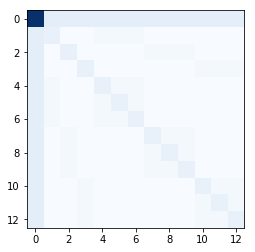

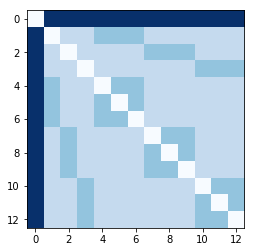

In [30]:
fig, ax = plt.subplots(); ax.imshow(             R , cmap='Blues');
fig, ax = plt.subplots(); ax.imshow(without_diag(R), cmap='Blues');

## Interactive experiments

In [31]:
import ipywidgets

In [32]:
from collections import OrderedDict

In [33]:
pexit_widget = ipywidgets.FloatSlider(0.5, min=0, max=1, step=0.05)
pexit_widget.layout.display = 'none'

auto_pexit_widget = ipywidgets.Checkbox(True, description="Auto-assign pexit")
def _observe_checkbox(change):
    pexit_widget.layout.display = 'none' if change['new'] else 'flex'
auto_pexit_widget.observe(_observe_checkbox, names='value')

@ipywidgets.interact_manual(
    select_graph = OrderedDict(graphs),
    combo_size = ipywidgets.Dropdown(value = 2, options = [1,2,3]),
    include_diag = [False, True],
    use_conditional = [False, True],
    alpha_scale = ipywidgets.FloatLogSlider(1, min=-2, max=1, step=0.1),
    auto_pexit = auto_pexit_widget,
    pexit = pexit_widget,
)
def _view_results(select_graph, combo_size, include_diag, use_conditional, alpha_scale, auto_pexit, pexit):
    global R, R_plot
    if auto_pexit:
        pexit = None
    R = compute_combo_tensor(select_graph, combo_size, alpha_func=partial(get_alpha, pexit=pexit, scale=alpha_scale))
    if use_conditional:
        R /= R.sum(axis=0)
    R_plot = R if include_diag else without_diag(R)
    R_plot = tensor_to_matrix(R_plot)
    fig, ax = plt.subplots(figsize=(20,4))
    ax.imshow(R_plot, cmap='Blues')
    ax.axis('off')
    ax.set_title("HPAM2")

interactive(children=(Dropdown(description='select_graph', options=OrderedDict([('Tree', <networkx.classes.dig…

Notes:
* Setting `pexit = 0` exactly corresponds to PAM above
* Setting `pexit = 0.423` **approximates** HPAM1 above
* Auto-assigning `pexit` exactly corresponds to HPAM2 above
  * For the Tree case, this corresponds exactly to `pexit = 0.25`
  * For the DAG case, this corresponds approximately to `pexit = 0.178`

The value 0.423 is an approximate minimizer of $\Vert(1/3, 1/3, 1/3) - (p, p(1-p), (1-p)^2)\Vert_1$.
In other words, this is the closest that HPAM2 can get to a uniform probability distribution over depths, which is used in the HPAM1 tests above.

The value 0.178 is an approximate minimizer of $\Vert(1/4, 3/40, 27/40) - (p, p(1-p), (1-p)^2)\Vert_1$.
In other words, this is the closest that a uniform value of `pexit` can get to a depth distribution of $(1/4, 3/40, 27/40)$ -- which is the exact depth distribution that we get from running HPAM2 on the fully-connected DAG and auto-assigning `pexit` on a per-node basis.

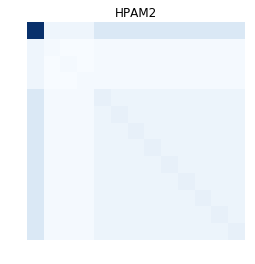

In [34]:
_view_results(
    select_graph=dense_dag,
    combo_size=2,
    include_diag=True,
    use_conditional=False,
    alpha_scale=1.0,
    auto_pexit=True,
    pexit=None,
)

In [35]:
depths = [0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
prob_by_depth = np.zeros(np.max(depths) + 1)
np.add.at(prob_by_depth, depths, R.sum(axis=0))
prob_by_depth

array([0.25 , 0.075, 0.675])

In [36]:
np.array([1/4, 3/40, 27/40])

array([0.25 , 0.075, 0.675])

In [37]:
from scipy.optimize import minimize_scalar

In [38]:
f = lambda x: np.array([x, x*(1-x), (1-x)**2])

In [39]:
target = np.array([1/3, 1/3, 1/3])
x = minimize_scalar(lambda x: np.linalg.norm(target - f(x), ord=1)).x
print("target = {}\nx = {} yields f(x) = {}".format(target, x, f(x)))

target = [0.33333333 0.33333333 0.33333333]
x = 0.4226497317237661 yields f(x) = [0.42264973 0.24401694 0.33333333]


In [40]:
target = np.array([1/4, 3/40, 27/40])
x = minimize_scalar(lambda x: np.linalg.norm(target - f(x), ord=1)).x
print("target = {}\nx = {} yields f(x) = {}".format(target, x, f(x)))

target = [0.25  0.075 0.675]
x = 0.17841616540420124 yields f(x) = [0.17841617 0.14658384 0.675     ]


## Tree Extraction

In [57]:
from tree_extraction import GreedyNoStructure, GreedyWithStructure, GreedyThreshold

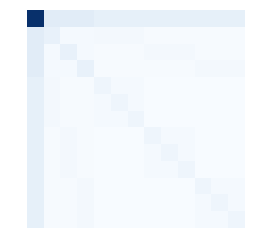

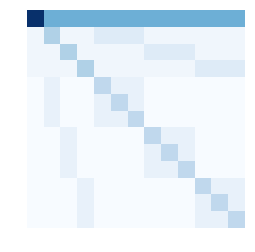

In [58]:
R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.3, scale=1.0))
niceimshow(R, cmap='Blues');
niceimshow(R / R.sum(axis=0), cmap='Blues')

In [59]:
diagnostics = []
t1 = GreedyNoStructure.extract(R, apply_cond = True, diagnostics = diagnostics)

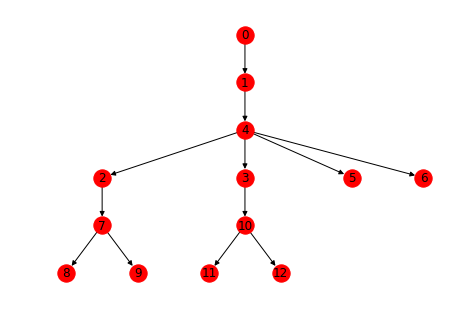

In [60]:
nx.draw(t1, pos=bfs_layout(t1), with_labels=True)

Select Root: 0
Add Edge: 0 --> 1
Add Edge: 1 --> 4
Add Edge: 4 --> 5
Add Edge: 4 --> 6
Add Edge: 4 --> 2
Add Edge: 2 --> 7
Add Edge: 7 --> 8
Add Edge: 7 --> 9
Add Edge: 4 --> 3
Add Edge: 3 --> 10
Add Edge: 10 --> 11
Add Edge: 10 --> 12


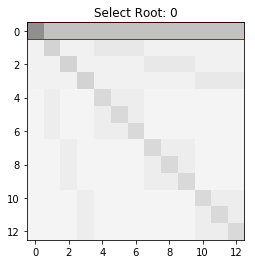

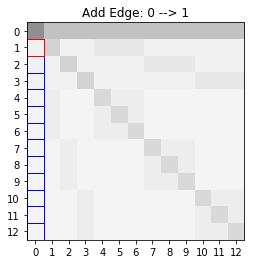

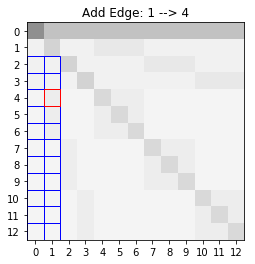

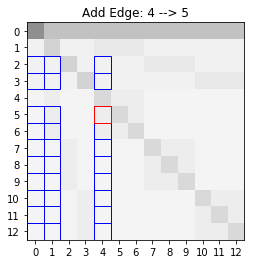

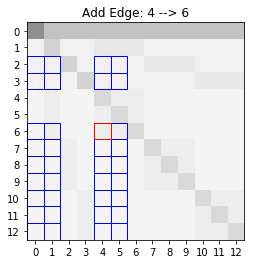

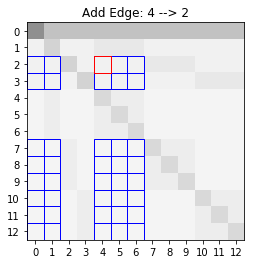

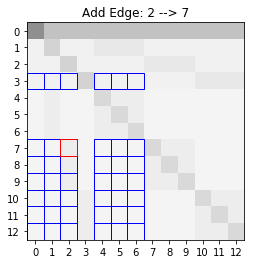

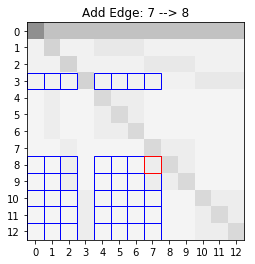

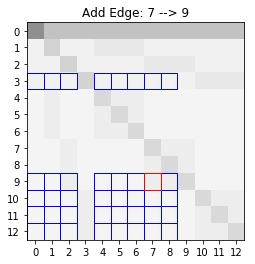

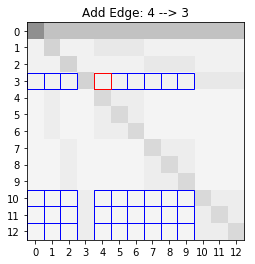

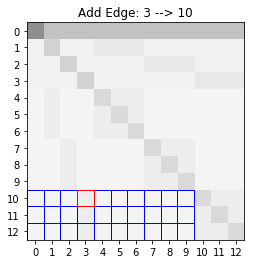

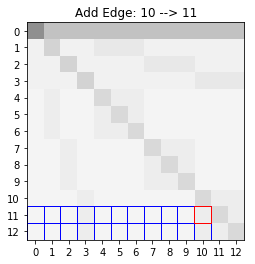

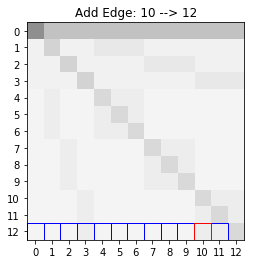

In [61]:
GreedyNoStructure.display_diagnostics(diagnostics)

In [63]:
t2 = GreedyWithStructure.extract(R, branching_factors=[3,3])

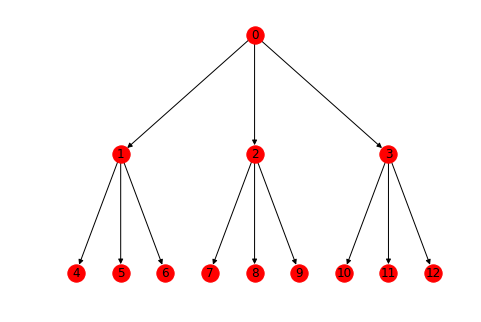

In [64]:
nx.draw(t2, pos=bfs_layout(t2), with_labels=True)

In [65]:
t3 = GreedyThreshold.extract(R, threshold = 0)

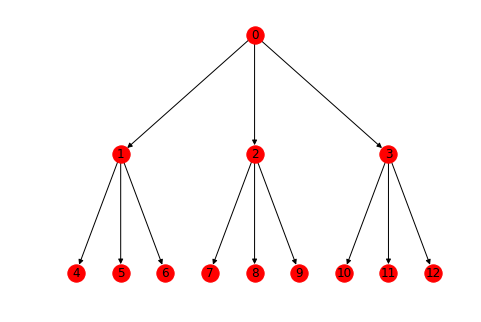

In [66]:
nx.draw(t3, pos=bfs_layout(t3), with_labels=True)

In [67]:
expected = {
    0: set([1,2,3]),
    1: set([4,5,6]),
    2: set([7,8,9]),
    3: set([10,11,12]),
}

In [73]:
def graph_diff(g, expected):
    result = {}
    all_nodes = set(g.nodes())
    for node in all_nodes:
        children_seen = set(g.neighbors(node))
        children_expected = set(expected.get(node, set()))
        if children_seen != children_expected:
            result[node] = {
                "actual": children_seen,
                "expected": children_expected,
            }
    for node in expected:
        if node not in all_nodes:
            result[node] = {
                "actual": set(),
                "expected": expected[node],
            }
    return result

In [74]:
graph_diff(tree, expected)

{}

In [75]:
graph_diff(t1, expected)

{0: {'actual': {1}, 'expected': {1, 2, 3}},
 1: {'actual': {4}, 'expected': {4, 5, 6}},
 2: {'actual': {7}, 'expected': {7, 8, 9}},
 3: {'actual': {10}, 'expected': {10, 11, 12}},
 4: {'actual': {2, 3, 5, 6}, 'expected': set()},
 7: {'actual': {8, 9}, 'expected': set()},
 10: {'actual': {11, 12}, 'expected': set()}}

In [76]:
graph_diff(t2, expected)

{}

In [77]:
graph_diff(t3, expected)

{}